## Import packages and Dataframe

In [12]:
import importlib as imp
import graph_statistics
import graph_analysis

In [13]:
imp.reload(graph_statistics)
imp.reload(graph_analysis)

<module 'graph_analysis' from 'C:\\Users\\SIMONE\\Desktop\\Movielens - Big\\graph_analysis.py'>

In [14]:
from graph_analysis import *
from graph_statistics import *

In [7]:
import scipy.spatial.distance as dist
from scipy.stats import pearsonr

# Louvain algorithm
import community

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
df = pd.read_csv('csv/dataframe.csv',index_col=0,parse_dates=['date'],dtype={'userId': int,'movieId': str,'year': int})
df.sort_index(inplace=True)
df.head(5)

,userId,movieId,rating,date,title,genres,year
0,1,m31,2.5,2009-12-14,Dangerous Minds (1995),Drama,1995
1,7,m31,3.0,1996-12-29,Dangerous Minds (1995),Drama,1995
2,31,m31,4.0,2010-05-11,Dangerous Minds (1995),Drama,1995
3,32,m31,4.0,1996-06-15,Dangerous Minds (1995),Drama,1995
4,36,m31,3.0,1996-11-03,Dangerous Minds (1995),Drama,1995


### Bipartite Graph

In [9]:
G,users,movies = create_bipartite_graph(df,rating=True,rating_cutoff=0.0)

In [10]:
# Delete low ratings for Jaccard projection
F = G.copy()
F.remove_edges_from([(u,v) for u,v,k in F.edges(data=True) if k['rating'] < 3])

### Projections - COS/EUC/PEAR/JAC

In [15]:
G_us_cos = user_projection_cosine(G)

In [16]:
G_us_euc = user_projection_euclidian(G)

In [17]:
G_us_pear = user_projection_pearson(G,users)

In [18]:
G_us_jac = user_projection_jac(F,users)

In [19]:
# Density 
print(nx.density(G_us_cos))
print(nx.density(G_us_euc))
print(nx.density(G_us_pear))
print(nx.density(G_us_jac))

0.8798629801810619
0.99999555130458
1.0
0.8465867384389528


In order to treat a sparser network, weak-strength links need slicing according
to a cut-off threshold. However, if the cut-off is too high, the network falls apart
into tiny disjoint fragments; if it is too low, the network becomes a hairball with no
meaningful structure [12]. The slicing procedure is initially based on the density
that will yield the appropriate weight cut-off for each measure. The links are first
ordered in decreasing order by weight and once their counting amounts to the density
threshold, all the remaining weak links are removed from the projected network.


The optimal threshold (empirically estimated) is expected to generate few isolated
nodes and will be evaluated in terms of modularity. This quantity ranges
from -1 to 1 on the basis of the quality of the community structures retrieved.
Networks with high modularity host nodes densely connected within communities
but sparsely linked to nodes in different groups.


The Louvain algorithm has proved to be the most efficient and accurate for
detecting communities in large networks [13]. It employs a greedy approach to
optimize the modularity, but is able to unveil hierarchies of communities at different
scales. The procedure consists of two steps. Firstly, it looks for small communities
by optimizing modularity locally. Secondly, it aggregates nodes belonging to the
same community and represent them as super-nodes of a new network. These steps
are repeated iteratively until a maximum of modularity is attained and a hierarchy
of communities is produced.

### Best cut according to modularity

In [20]:
# Slice first according to a density and then compute modularity

DENSITY = np.linspace(0.05,0.8,16,endpoint=True)
DENSITY = list(map(lambda x: round(x,2),DENSITY))

In [21]:
name = ['Pearson','Jacard','Cosine','Euclidean']

In [22]:
def slice_density(G,d,copy = True):
    
    F = G.copy() if copy else G
    count = int(len(G.nodes()) * (len(G.nodes()) - 1) * d)/2
    rand = sorted(list(G.edges(data=True)),key=lambda x: x[2]['weight'], reverse=False)[0:int(len(G.edges())-count)]
    l = [(u,v) for u,v,w in list(rand)]
    F.remove_edges_from(l)
    return F

In [23]:
networks = defaultdict(dict)

for i in range(len(DENSITY)):
    networks[i] = [slice_density(G_us_pear,DENSITY[i]),
                   slice_density(G_us_jac,DENSITY[i]),
                   slice_density(G_us_cos,DENSITY[i]),slice_density(G_us_euc,DENSITY[i])]

In [28]:
networks_conn = defaultdict(list)

mod = defaultdict(list)
n_part = defaultdict(list)
n_iso = defaultdict(list)
n_gcc = defaultdict(list)

name = ['Pearson','Jacard','Cosine','Euclidean']

for i in range(len(DENSITY)):
        for j in range(len(name)):
            n_iso[name[j]].append(len(list(nx.isolates(networks[i][j]))))
            n_gcc[name[j]].append(len(max(nx.strongly_connected_component_subgraphs(nx.DiGraph(networks[i][j])),key = len)))
            
            networks_conn = nx.Graph(networks[i][j])
            networks_conn.remove_nodes_from(list(nx.isolates(networks_conn)))
            partitions = community.best_partition(networks_conn)
            mod[name[j]].append(community.modularity(partitions, networks_conn))
            n_part[name[j]].append(len(set(partitions.values())))
            
modularity_df = pd.DataFrame(mod,index = DENSITY)
modularity_df.index.name = 'Density'

part_df = pd.DataFrame(n_part,index = DENSITY)
part_df.index.name = 'Density'

iso_df = pd.DataFrame(n_iso,index = DENSITY)
iso_df.index.name = 'Density'
iso_df = iso_df/len(users)

gcc_df = pd.DataFrame(n_gcc,index = DENSITY)
gcc_df.index.name = 'Density'

In [29]:
# Stor network statistics
modularity_df.to_csv('modularity_df.csv')
part_df.to_csv('partitions.csv')
iso_df.to_csv('isolates.csv')
gcc_df.to_csv('gcc.csv')

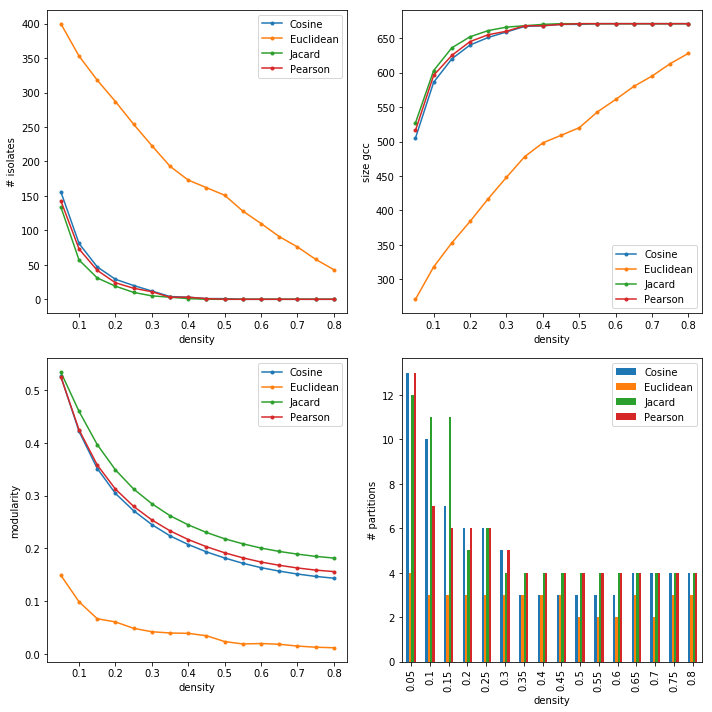

In [33]:
_,axs = plt.subplots(2,2,figsize=(10,10))

(iso_df*len(users)).plot(ax=axs[0,0],style='.-')
axs[0,0].set_ylabel('# isolates')
axs[0,0].set_xlabel('density')
#axs[0,0].set_xlim((0.05,0.3))
#axs[0,0].set_ylim((0.0,200))

gcc_df.plot(ax=axs[0,1],style='.-')
axs[0,1].set_ylabel('size gcc')
axs[0,1].set_xlabel('density')
#axs[0,1].set_xlim((0.05,0.3))
#axs[0,1].set_ylim((500,700))

modularity_df.plot(ax=axs[1,0],style='.-')
axs[1,0].set_ylabel('modularity')
axs[1,0].set_xlabel('density')
#axs[1,0].set_xlim((0.05,0.3))
#axs[1,0].set_ylim((0.2,0.6))

part_df.plot.bar(ax = axs[1,1],style='.-')
axs[1,1].set_ylabel('# partitions')
axs[1,1].set_xlabel('density')


plt.tight_layout()
plt.show()

Among all the metrics, JAC achieves the best performance. We remark, however,
that we first cut weak user-item links off (ratings below 3.0) in the bipartite
network to calculate this measure. PEAR slightly overtakes COS and as additional
benefit connects a few more users.


From this point forward, we will only refer to users in the projected network.
The density threshold is expected to exclude few users and yield high modularity,
that may help casting good recommendations based on common tastes within a
community. A good trade-off is the density 0.20, whose network statistics are reported
in Table

In [34]:
df_sum = pd.concat([iso_df.iloc[3,:]*len(users),gcc_df.iloc[3,:],part_df.iloc[3,:],modularity_df.iloc[3,:],],axis=1).transpose()
df_sum.index = ['# isolates','size gcc','# communities','modularity']
df_sum.index.name = 'density: 0.2'

In [35]:
df_sum

,Cosine,Euclidean,Jacard,Pearson
density: 0.2,,,,
# isolates,29.000000,287.000000,19.000000,24.000000
size gcc,640.000000,384.000000,652.000000,645.000000
# communities,6.000000,3.000000,5.000000,6.000000
modularity,0.303872,0.060644,0.348564,0.312145


### Quality of Communities

The user network is made up of 671 nodes, by which 24 are isolates and 645 constitute
the greatest connected component. The plot reports the number
of users belonging to each partition. Apart from the first and last partition, the
Louvain algorithm has identified 3 representative communities.

In [36]:
part = defaultdict(pd.Series)

net_conn = slice_density(G_us_pear,0.20)
net_conn.remove_nodes_from(list(nx.isolates(net_conn)))

part_dict = pd.Series(community.best_partition(net_conn)).to_dict()
ser = pd.Series(collections.Counter(part_dict.values()))
part_ser = ser[ser >= 2]
part_ser.index = np.arange(0,len(part_ser))

In [37]:
part_values = set(community.best_partition(net_conn).values())

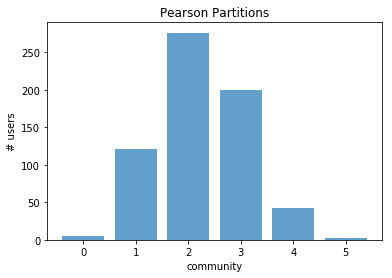

In [38]:
plt.bar(height = part_ser,x=part_ser.index,alpha = 0.7)

plt.title('Pearson Partitions')
plt.ylabel('# users')
plt.xlabel('community')
plt.show()

In [39]:
# write partition as pkl file
f = open("partition_user.pkl","wb")
pickle.dump(community.best_partition(net_conn),f)
f.close()

#### Partition's attributes

In [40]:
df['genres'] = df['genres'].apply(lambda x: x.split('|'))

In [41]:
g = df.groupby('userId')[['genres']].agg(sum)

In [42]:
def normalize(d, target=1):
    
    raw = sum(d.values())
    
    factor = target/raw
     
    return {key: round(value*factor,3) for key,value in d.items() }

In [43]:
def keys_max(d):
    
    v=list(d.values())
    k=list(d.keys())
    
    k_1,k_2,k_3 = sorted(d,key = lambda key: d[key],reverse = True)[0:3]   
    
    return k_1,k_2,k_3

In [44]:
g_norm = g['genres'].apply(lambda x: dict(collections.Counter(x))).apply(normalize).to_dict()

In [45]:
genre_df = pd.DataFrame.from_dict(g['genres'].apply(lambda x: dict(collections.Counter(x))).apply(normalize).to_dict())
genre_df = genre_df.transpose()

In [46]:
dict_part = community.best_partition(net_conn)

In [47]:
part = []
part = [ [u for u,k in dict_part.items() if k == i] for i in part_values]

In [48]:
# Fill Na with 0
genre_df = genre_df.fillna(0)

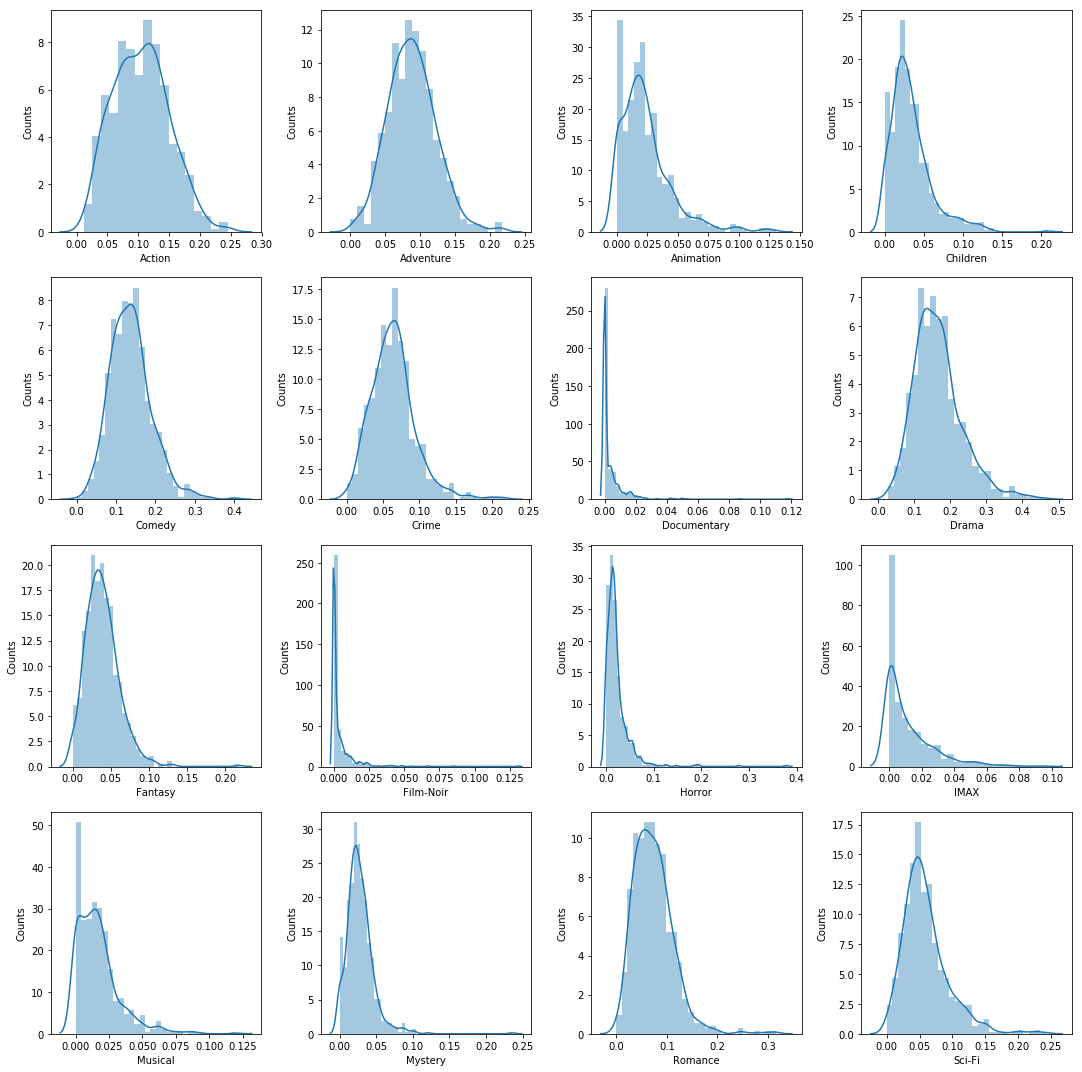

In [49]:
_,axis = plt.subplots(4,4,figsize=(15,15))

for i in range(16):
    sns.distplot(genre_df.iloc[:,i],norm_hist=True,ax = axis[i//4,i%4])
    axis[i//4,i%4].set_ylabel('Counts')

plt.tight_layout()
plt.show()

We can qualitatively distinguish taste in genres for partition 2 and 3. The former
community hosts users passionate about Adventure and Action movies, whereas the
latter is marked by a preference in Romance and Drama. Partition 1 stands out as
fond of Thriller, Action and Adventure movies.

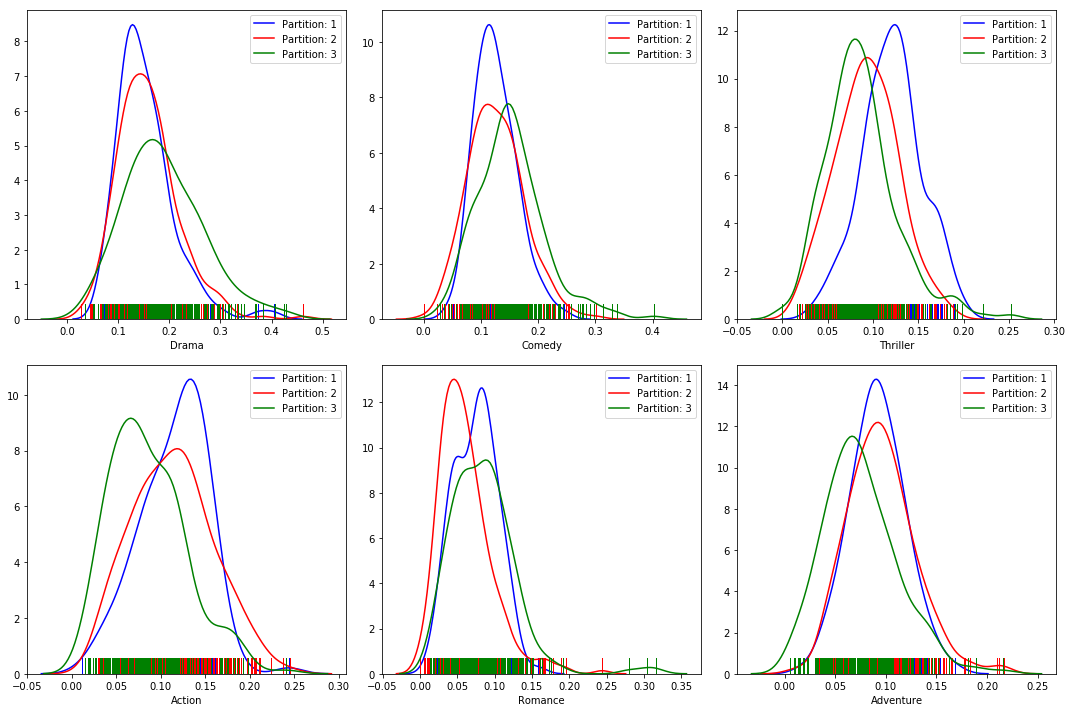

In [50]:
_,axis = plt.subplots(2,3,figsize=(15,10))

sns.distplot(genre_df.loc[part[1],'Drama'], ax=axis[0,0],color='blue',hist=False,norm_hist=True,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Drama'], ax=axis[0,0],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Drama'], ax=axis[0,0],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Comedy'], ax=axis[0,1],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Comedy'], ax=axis[0,1],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Comedy'], ax=axis[0,1],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Thriller'], ax=axis[0,2],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Thriller'], ax=axis[0,2],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Thriller'], ax=axis[0,2],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Action'], ax=axis[1,0],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Action'], ax=axis[1,0],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Action'], ax=axis[1,0],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Romance'], ax=axis[1,1],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Romance'], ax=axis[1,1],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Romance'], ax=axis[1,1],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

sns.distplot(genre_df.loc[part[1],'Adventure'], ax=axis[1,2],color='blue',hist=False,rug=True,label = 'Partition: {}'.format(1))
sns.distplot(genre_df.loc[part[2],'Adventure'], ax=axis[1,2],color='red',hist=False,rug=True,label = 'Partition: {}'.format(2))
sns.distplot(genre_df.loc[part[3],'Adventure'], ax=axis[1,2],color='green',hist=False,rug=True,label = 'Partition: {}'.format(3))

plt.tight_layout()
plt.show()

### Weight Distribution

In [51]:
count = int(len(G_us_jac.nodes()) * (len(G_us_jac.nodes()) - 1) * 0.20)/2

w0 = sorted(list(G_us_jac.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_jac.nodes())-count)][2]['weight']

In [52]:
count = int(len(G_us_pear.nodes()) * (len(G_us_pear.nodes()) - 1) * 0.20)/2

w1 = sorted(list(G_us_pear.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_pear.nodes())-count)][2]['weight']

In [53]:
count = int(len(G_us_cos.nodes()) * (len(G_us_cos.nodes()) - 1) * 0.20)/2

w2 = sorted(list(G_us_cos.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_jac.nodes())-count)][2]['weight']

In [54]:
count = int(len(G_us_euc.nodes()) * (len(G_us_euc.nodes()) - 1) * 0.20)/2

w3 = sorted(list(G_us_euc.edges(data=True)),key=lambda x: x[2]['weight'],reverse=False)[int(len(G_us_jac.nodes())-count)][2]['weight']

In [55]:
w0,w1,w2,w3

(0.06432748538011696, 0.14712612, 0.1591774, 0.7931671)

In [56]:
wd = np.array([k['weight'] for u,m,k in list(G_us_jac.edges(data=True))])
wd_pear = np.array([k['weight'] for u,m,k in list(G_us_pear.edges(data=True)) if k['weight'] > 0])
wd_cos = np.array([k['weight'] for u,m,k in list(G_us_cos.edges(data=True)) if k['weight'] > 0])
wd_euc = np.array([k['weight'] for u,m,k in list(G_us_euc.edges(data=True)) if k['weight'] > 0])

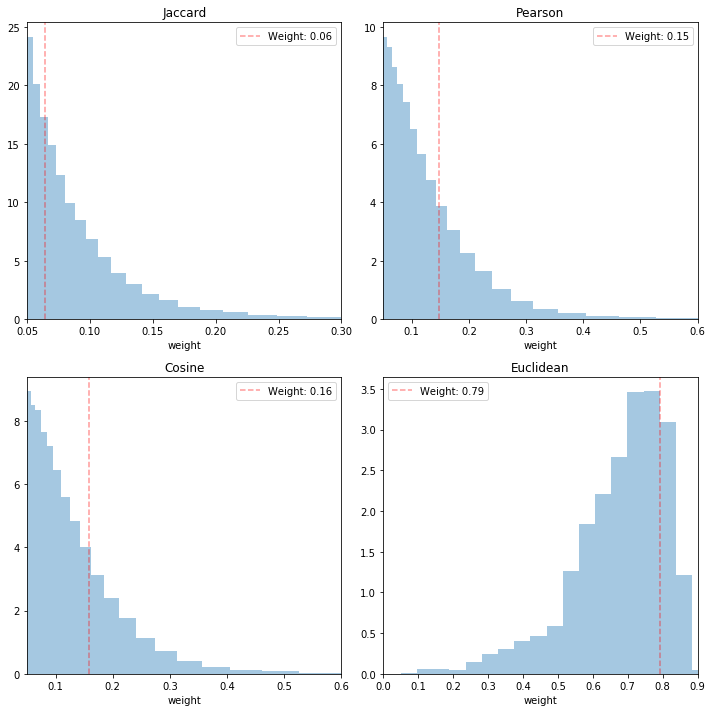

In [57]:
_,axs = plt.subplots(2,2,figsize=(10,10))

sns.distplot(wd,norm_hist=True,kde = False,bins = np.logspace(np.log10(0.05),np.log10(0.3),20),ax = axs[0,0])
axs[0,0].set_xlim((0.05,0.3))
axs[0,0].set_xlabel('weight')
axs[0,0].set_title('Jaccard')
axs[0,0].axvline(w0,c='r',linestyle = '--',label = 'Weight: {}'.format(np.round(w0,2)),alpha= 0.4)
axs[0,0].legend()

sns.distplot(wd_pear,norm_hist=True,kde = False,bins = np.logspace(np.log10(0.05),np.log10(0.6),20),ax = axs[0,1])
axs[0,1].set_xlabel('weight')
axs[0,1].set_xlim((0.05,0.6))
axs[0,1].set_title('Pearson')
axs[0,1].axvline(w1,c='r',linestyle = '--',label = 'Weight: {}'.format(0.15),alpha= 0.4)
axs[0,1].legend()

sns.distplot(wd_cos,norm_hist=True,kde = False,bins = np.logspace(np.log10(0.05),np.log10(0.6),20),ax = axs[1,0])
axs[1,0].set_xlabel('weight')
axs[1,0].set_xlim((0.05,0.6))
axs[1,0].set_title('Cosine')
axs[1,0].axvline(w2,c='r',linestyle = '--',label = 'Weight: {}'.format(0.16),alpha= 0.4)
axs[1,0].legend()

sns.distplot(wd_euc,norm_hist=True,kde = False,bins = 20,ax = axs[1,1])
axs[1,1].set_xlabel('weight')
axs[1,1].set_xlim((0.0,0.9))
axs[1,1].set_title('Euclidean')
axs[1,1].axvline(w3,c='r',linestyle = '--',label = 'Weight: {}'.format(0.79),alpha= 0.4)
axs[1,1].legend()

plt.tight_layout()
plt.show()

The distribution of the first three metrics are in agreement with the user-tomovie
degree distribution: Active users decay as a power-law, as well
as strong links they are likely to form with other users follow the same tendency.
EUC instead shrinks the distribution towards high weights, suggesting that the
max distance used for normalizing the similarity values is too high and inappropriate
for the purposes of our analysis.

Henceforth, PEAR will be employed as it is better representative of the total
ratings, both positive and negative, assigned by users.